### Vzorci v minimalnih grafih

Minimalni grafi za ciklomatično število $k$ temeljijo na ciklu $C_n$ z $k$ 
dodatnimi povezavami, razporejenimi čim bolj enakomerno.

Ko $n$ narašča, se dodatne povezave razporedijo na približno enakih razdaljah 
po ciklu, kjer:
- $C_n$ je osnovna ciklična struktura
- $k$ dodatnih povezav povezuje oddaljena vozlišča
- Enakomerna razporeditev minimizira razlike med stopnjami

In [1]:
from sage.numerical.mip import MixedIntegerLinearProgram
from sage.all import *
import networkx as nx
import random
import math
import os
import matplotlib.pyplot as plt

# MILP

def valid_parameters(n, k):
    if n < 1 or k < 0 or \
        n + k - 1 > (n * (n -1)) // 2 or \
        k > (n * (n -1)) // 2 - (n - 1):
        return False 
    return True

def min_problem_MILP(n, k, solver_name='GLPK', verbose=True):
    if not valid_parameters(n, k):
        if verbose:
            print("Parameters not valid.")
        return None

    n = int(n); k = int(k)
    V = list(range(1, n+1))
    E = [(i,j) for i in V for j in V if i < j]
    T = list(range(0, n))
    m_edges = n - 1 + k
    M_big = (n-1)**2 + 222
    root = 1

    p = MixedIntegerLinearProgram(maximization=False, solver=solver_name)
    x = p.new_variable(binary=True)
    y = p.new_variable(binary=True)
    s = p.new_variable(nonnegative=True)
    z = p.new_variable(nonnegative=True)
    f = p.new_variable(nonnegative=True, integer=True)

    for i in V:
        p.add_constraint(sum(y[i,t] for t in T) == 1)
    for i in V:
        p.add_constraint(
            sum(x[min(i,j), max(i,j)] for j in V if j != i)
            == sum(t * y[i,t] for t in T)
        )
    for i in V:
        p.add_constraint(s[i] == sum((t*t) * y[i,t] for t in T))
    p.add_constraint(sum(x[i,j] for (i,j) in E) == m_edges)
    for (i,j) in E:
        p.add_constraint(z[i,j] >= s[i] - s[j]- M_big * (1- x[i,j]))
        p.add_constraint(z[i,j] >= s[j] - s[i] - M_big * (1- x[i,j]))
    for u in V:
        for v in V:
            if u == v: continue
            i,j = (u,v) if u < v else (v,u)
            p.add_constraint(f[u,v] <= (n-1) * x[i,j])
    for i in V:
        if i == root: continue
        p.add_constraint(
            sum(f[u,i] for u in V if u != i) - sum(f[i,v] for v in V if v != i) == 1
        )
    p.add_constraint(sum(f[root,v] for v in V if v != root) == n-1)
    p.set_objective(sum(z[i,j] for (i,j) in E))

    try:
        p.solve()
    except Exception as e:
        if verbose:
            print("Solver raised exception:", e)
        return None

    obj = p.get_objective_value()
    xvals = p.get_values(x)
    edges = [e for e,v in xvals.items() if v > 0.5]
    
    if verbose:
        print("Solver objective:", obj)
        print("Edges (m=%d): %s" % (len(edges), sorted(edges)))
    
    return dict(objective=obj, edges=edges, method='MILP')

# NetworkX SA 

class SA:
    def __init__(self, functions, G, _type='min', T=1000.0, u=0.995):
        self.functions = functions
        self.type = _type
        self.G = G.copy()
        self.E = self.cM2(G)
        self.T = T 
        self.u = u 
        self.best_state = G.copy()
        self.best_E = self.E
    
    @staticmethod
    def cM2(G):
        degrees = dict(G.degree())
        return sum(abs(degrees[u]**2 - degrees[v]**2) for u, v in G.edges())

    def accept(self, state_next, E_state, E_next):
        change = E_next - E_state
        if (change < 0 and self.type == 'min') or (change > 0 and self.type == 'max'):
            self.best_state = state_next
            self.best_E = E_next
            return True
        return random.random() < self.functions.cooling_function(change, self)
    
    def new_state(self):
        edges = list(self.G.edges())
        non_edges = list(nx.non_edges(self.G))
        if not non_edges:
            return self.G
        
        max_attempts = 50
        for _ in range(max_attempts):
            H = self.G.copy()
            u_v = self.functions.edge_to_remove(self, edges, non_edges)
            w_x = self.functions.edge_to_add(self, edges, non_edges)
            H.remove_edge(*u_v)
            H.add_edge(*w_x)
            if nx.is_connected(H):
                return H
        return self.G
            
    def simulated_annealing(self, verbose=False):
        while self.T > 1:
            state_next = self.new_state()
            E_next = self.cM2(state_next)
            if self.accept(state_next, self.E, E_next):
                self.G = state_next
                self.E = E_next
            self.T *= self.u
        
        if verbose:
            print(f"Best Energy: {self.best_E}")
        return (self.best_state, self.best_E)

class FunctionsMin2:
    def __init__(self):
        self.pick = None

    @staticmethod
    def cooling_function(change, milp):
        return math.exp(-change / milp.T)
    
    @staticmethod
    def cM2_test(milp, uv, wx):
        F = milp.G.copy() 
        F.remove_edge(*uv)
        F.add_edge(*wx)
        return milp.cM2(F)
    
    def edge_to_add(self, milp, edges, non_edges):
        if self.pick is None:
            raise ValueError("Unexpected.")
        return self.pick[1]
    
    def edge_to_remove(self, milp, edges, non_edges):
        candidates = [(uv, wx) for uv in edges for wx in non_edges]
        weights = {
            (uv, wx): self.cM2_test(milp, uv, wx) - milp.E
            for uv in edges for wx in non_edges
        }
        cf_weights = [
            self.cooling_function(change=weights[(uv, wx)], milp=milp) 
            for (uv, wx) in weights.keys()
        ]
        pick = random.choices(candidates, weights=cf_weights)[0]
        self.pick = pick
        return pick[0]

class FunctionsMax:
    def __init__(self):
        self.pick = None

    @staticmethod
    def cooling_function(change, milp):
        return math.exp(change / milp.T)
    
    @staticmethod
    def cM2_test(milp, uv, wx):
        F = milp.G.copy() 
        F.remove_edge(*uv)
        F.add_edge(*wx)
        return milp.cM2(F)
    
    def edge_to_add(self, milp, edges, non_edges):
        if self.pick is None:
            raise ValueError("Unexpected.")
        return self.pick[1]
    
    def edge_to_remove(self, milp, edges, non_edges):
        candidates = [(uv, wx) for uv in edges for wx in non_edges]
        weights = {
            (uv, wx): self.cM2_test(milp, uv, wx) - milp.E
            for uv in edges for wx in non_edges
        }
        cf_weights = [
            self.cooling_function(change=weights[(uv, wx)], milp=milp) 
            for (uv, wx) in weights.keys()
        ]
        pick = random.choices(candidates, weights=cf_weights)[0]
        self.pick = pick
        return pick[0]

def SA_networkx(n, k, minimize=True, T=5000.0, u=0.995, num_runs=2, verbose=False):
    m = n - 1 + k
    best_global = float('inf') if minimize else float('-inf')
    best_graph = None
    
    for run in range(num_runs):
        G = nx.gnm_random_graph(n, m, seed=None)
        while not nx.is_connected(G):
            G = nx.gnm_random_graph(n, m, seed=None)
        
        functions = FunctionsMin2() if minimize else FunctionsMax()
        sa = SA(
            functions=functions,
            G=G,
            _type='min' if minimize else 'max',
            T=T,
            u=u
        )
        best_state, best_E = sa.simulated_annealing(verbose=False)
        
        if (minimize and best_E < best_global) or (not minimize and best_E > best_global):
            best_global = best_E
            best_graph = best_state
        
        if verbose:
            print(f"  Run {run+1}: {best_E}")
    
    edges = [(min(u,v), max(u,v)) for u, v in best_graph.edges()]
    
    if verbose:
        print(f"Best: {best_global}")
    
    return dict(objective=best_global, edges=edges, method='SA')

print("✓ Vse funkcije naložene!")


✓ Vse funkcije naložene!


Min k=2
n=4, k=2: MILP objective=20.0
n=5, k=2: MILP objective=18.0
n=6, k=2: MILP objective=16.0
n=7, k=2: MILP objective=16.0
n=8, k=2: SA objective=16.0
n=9, k=2: SA objective=16.0
n=10, k=2: SA objective=16.0
n=11, k=2: SA objective=16.0
n=12, k=2: SA objective=16.0
n=13, k=2: SA objective=16.0
Min k=3
n=4, k=3: MILP objective=0.0
n=5, k=3: MILP objective=10.0
n=6, k=3: MILP objective=8.0
n=7, k=3: MILP objective=8.0
n=8, k=3: SA objective=8.0
n=9, k=3: SA objective=8.0
n=10, k=3: SA objective=8.0
n=11, k=3: SA objective=8.0
n=12, k=3: SA objective=8.0
n=13, k=3: SA objective=8.0
Min k=4
n=5, k=4: MILP objective=28.0
n=6, k=4: MILP objective=0.0
n=7, k=4: MILP objective=10.0
n=8, k=4: SA objective=8.0
n=9, k=4: SA objective=8.0
n=10, k=4: SA objective=8.0
n=11, k=4: SA objective=8.0
n=12, k=4: SA objective=8.0
n=13, k=4: SA objective=8.0
Min k=5
n=5, k=5: MILP objective=42.0
n=6, k=5: MILP objective=36.0
n=7, k=5: MILP objective=28.0
n=8, k=5: SA objective=0.0
n=9, k=5: SA objectiv

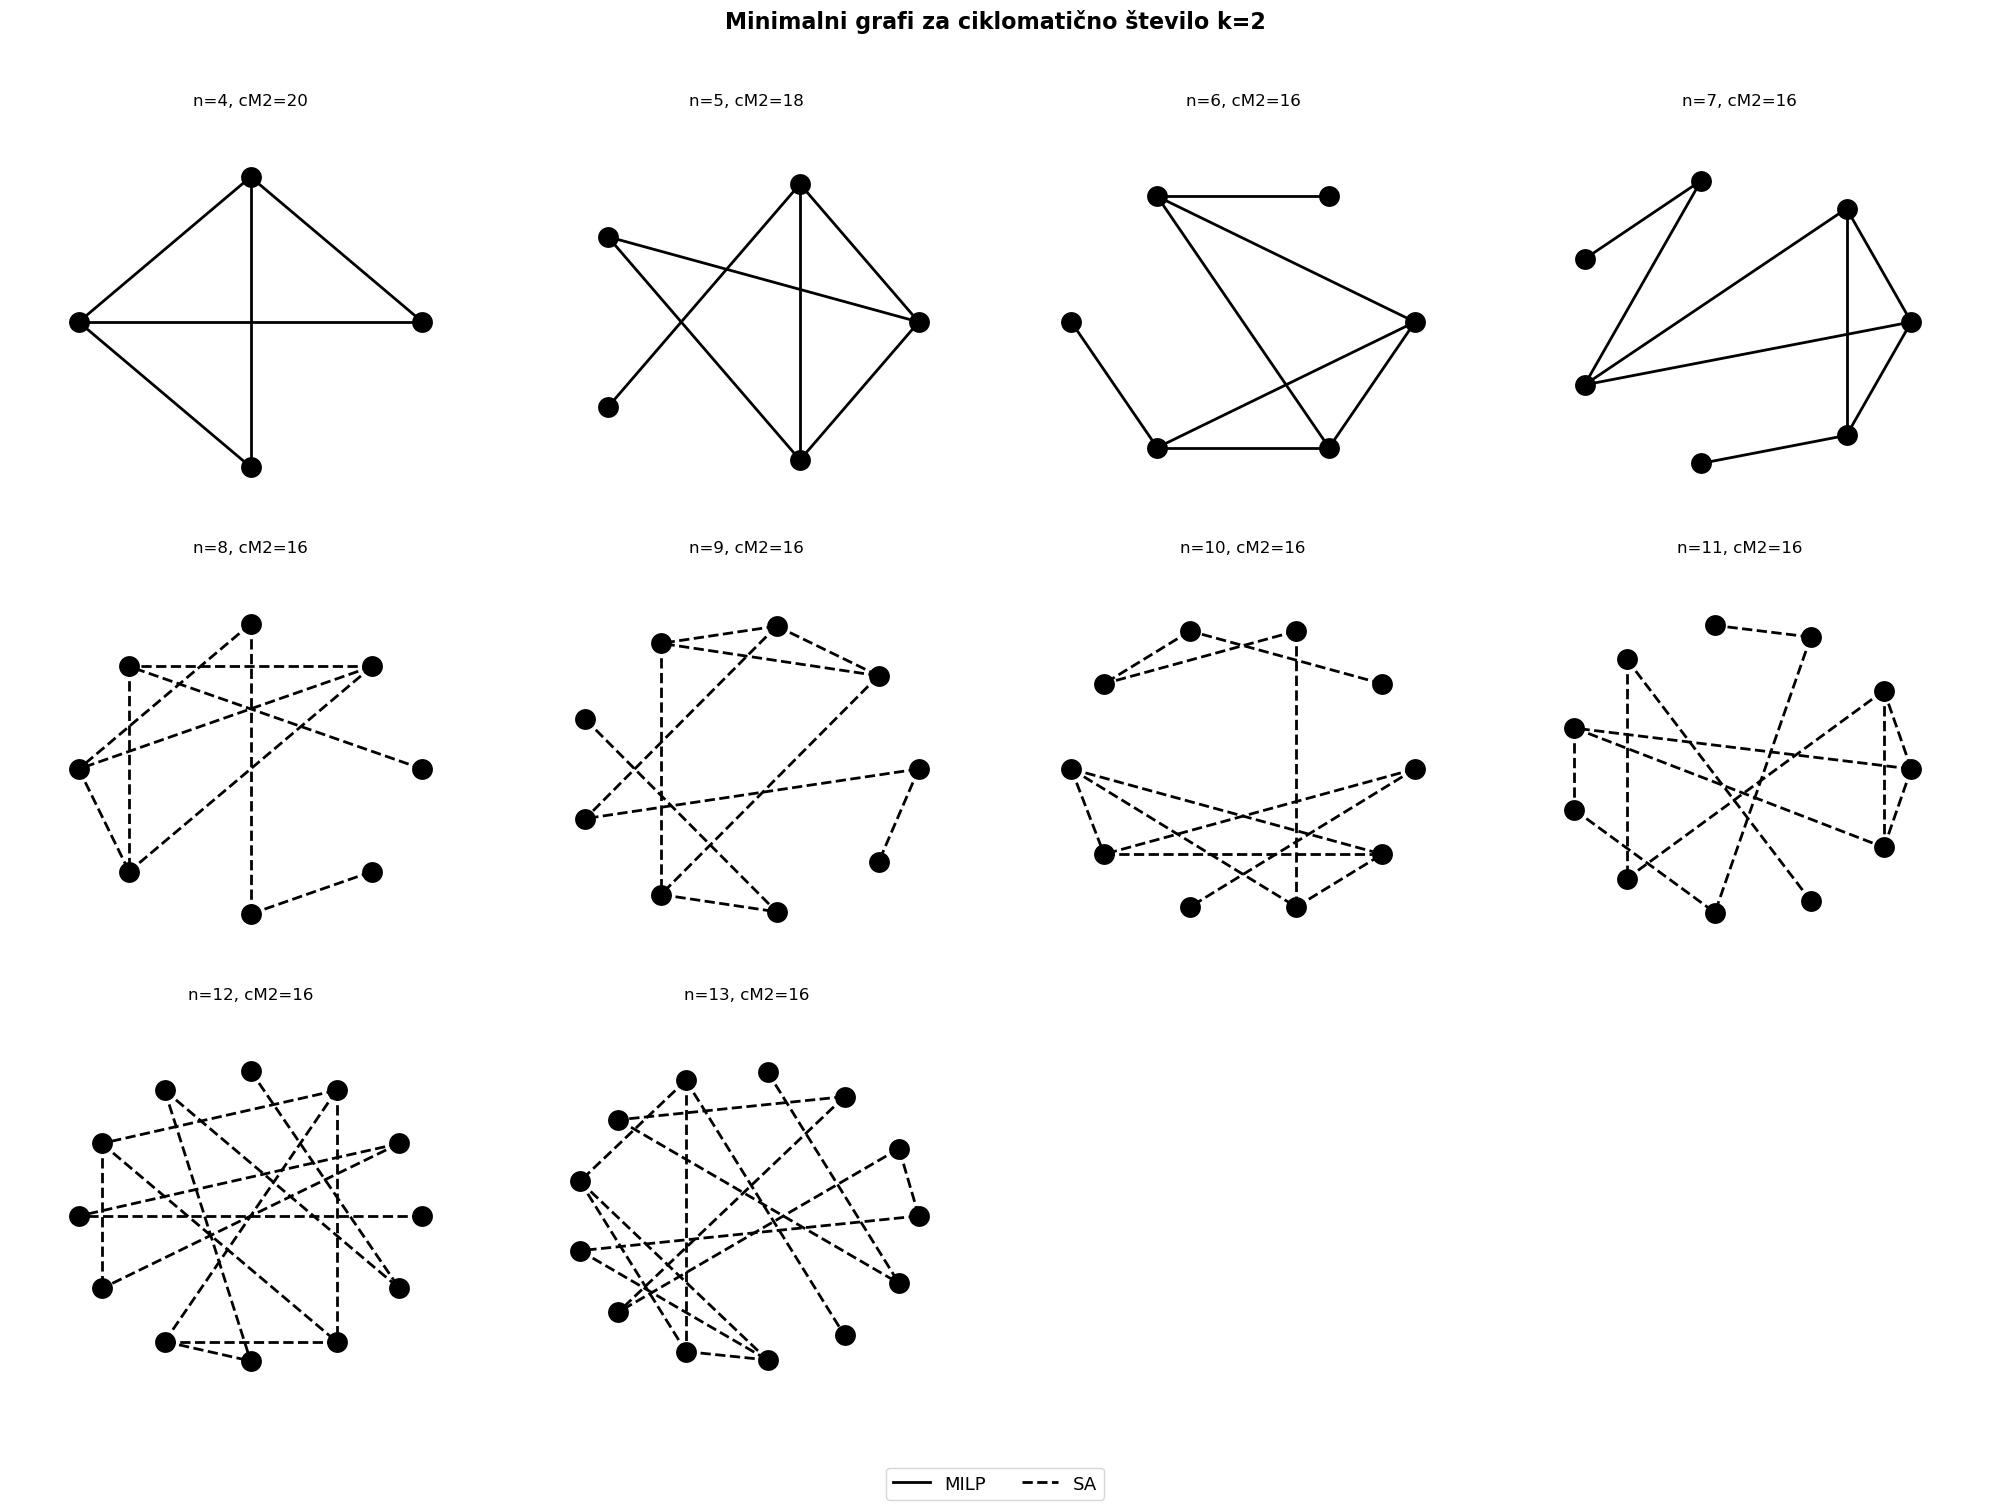

✓ Shranjeno: images/minimal_graphs/minimal_k3_final.png


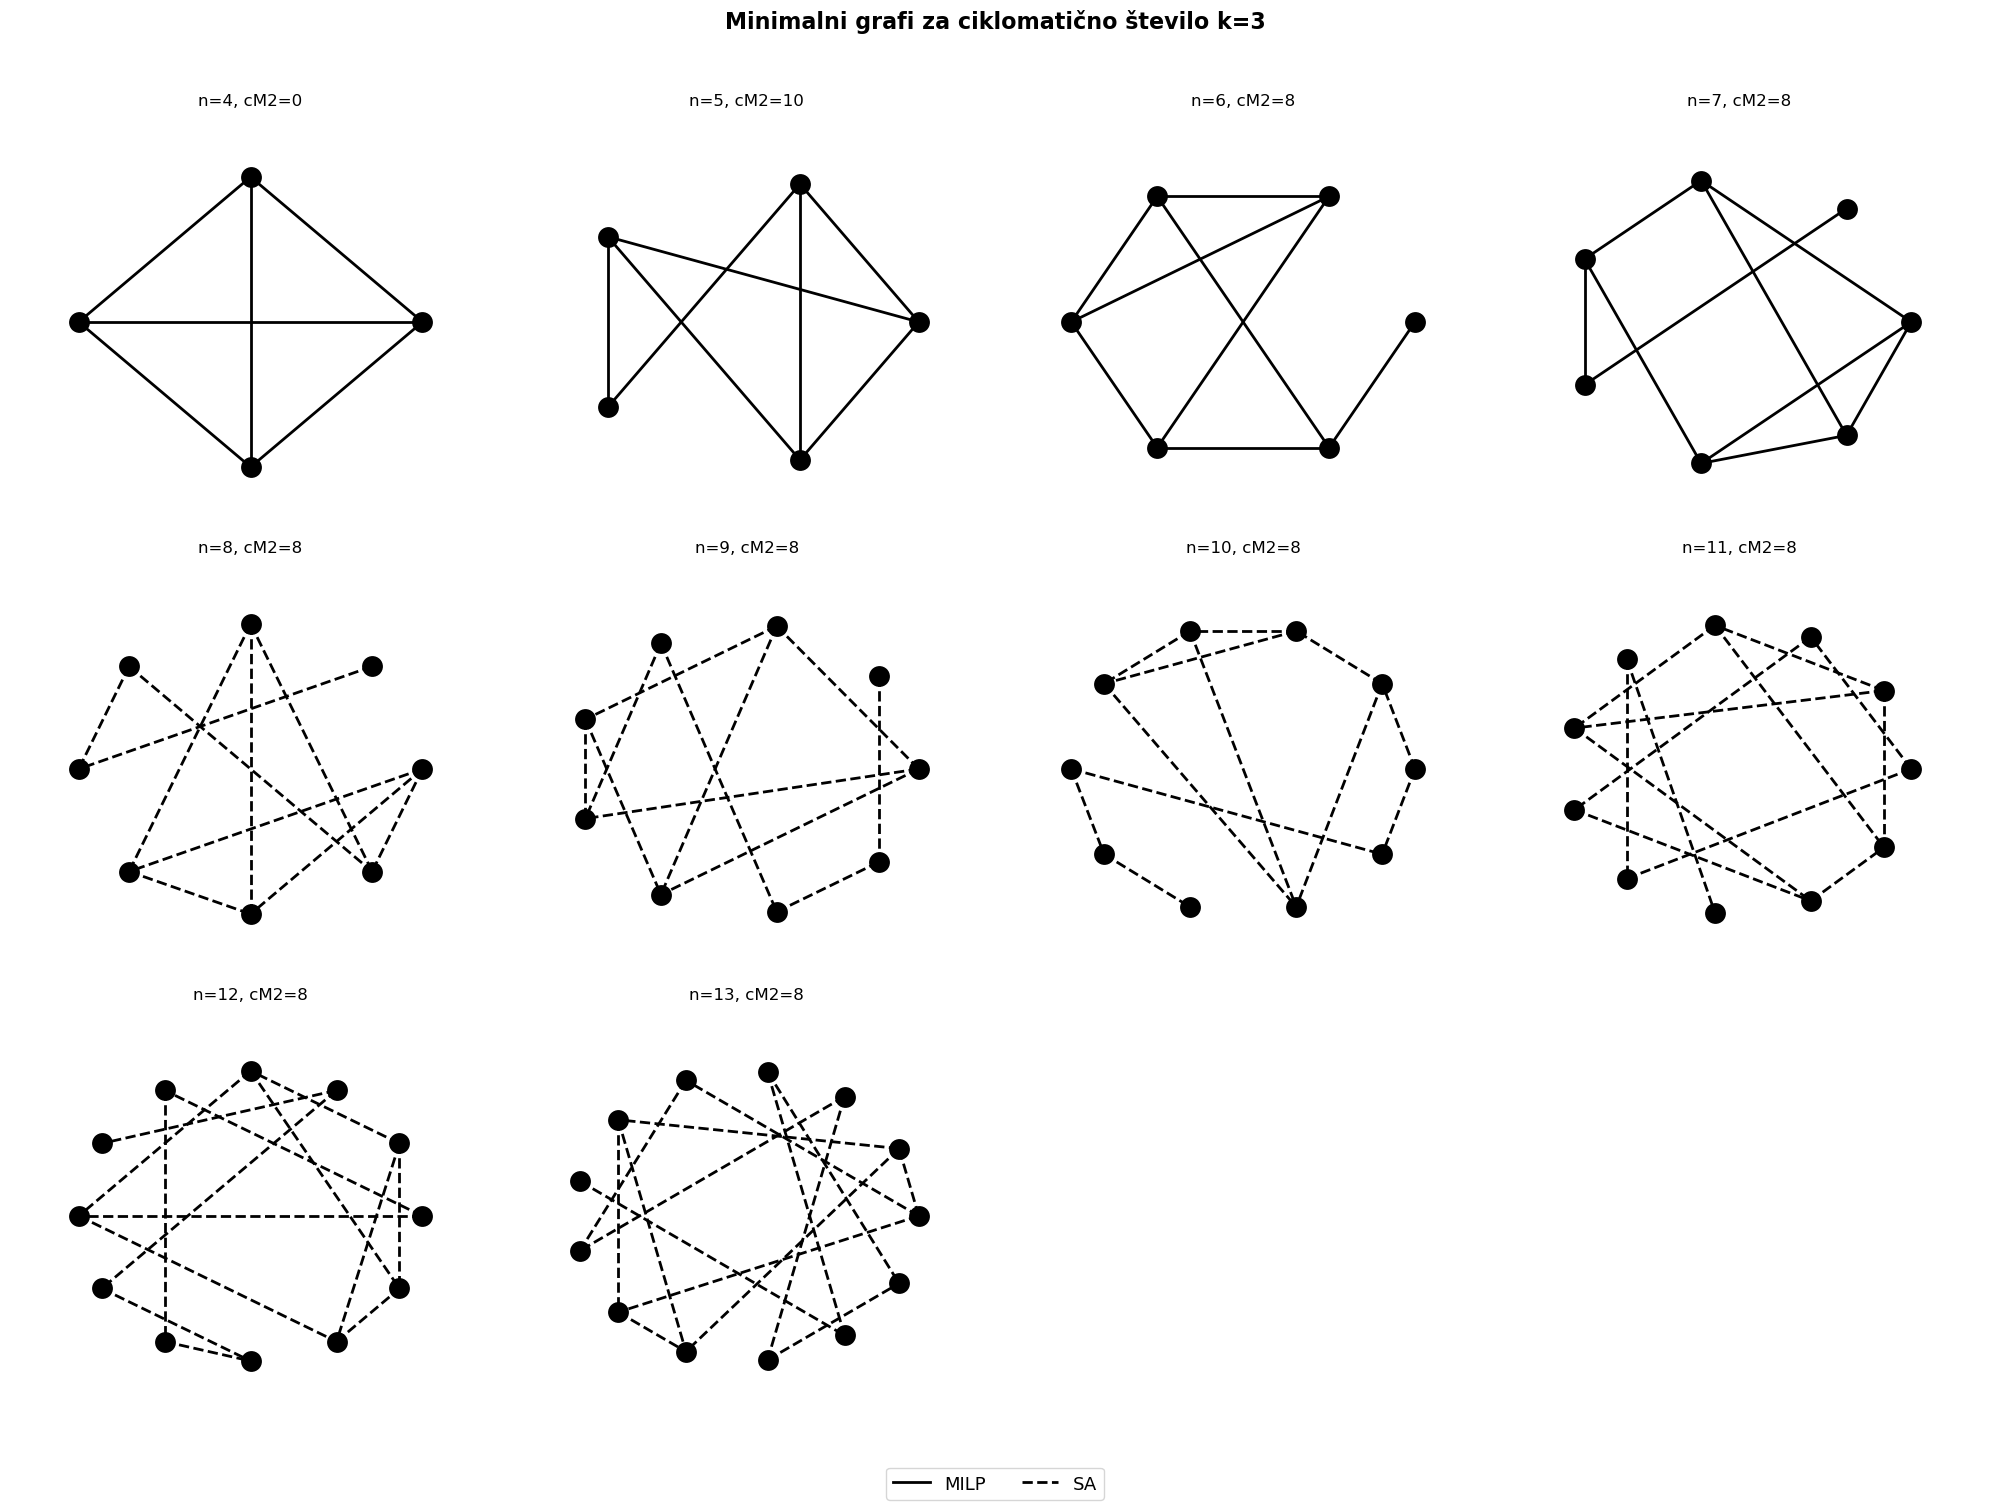

✓ Shranjeno: images/minimal_graphs/minimal_k4_final.png


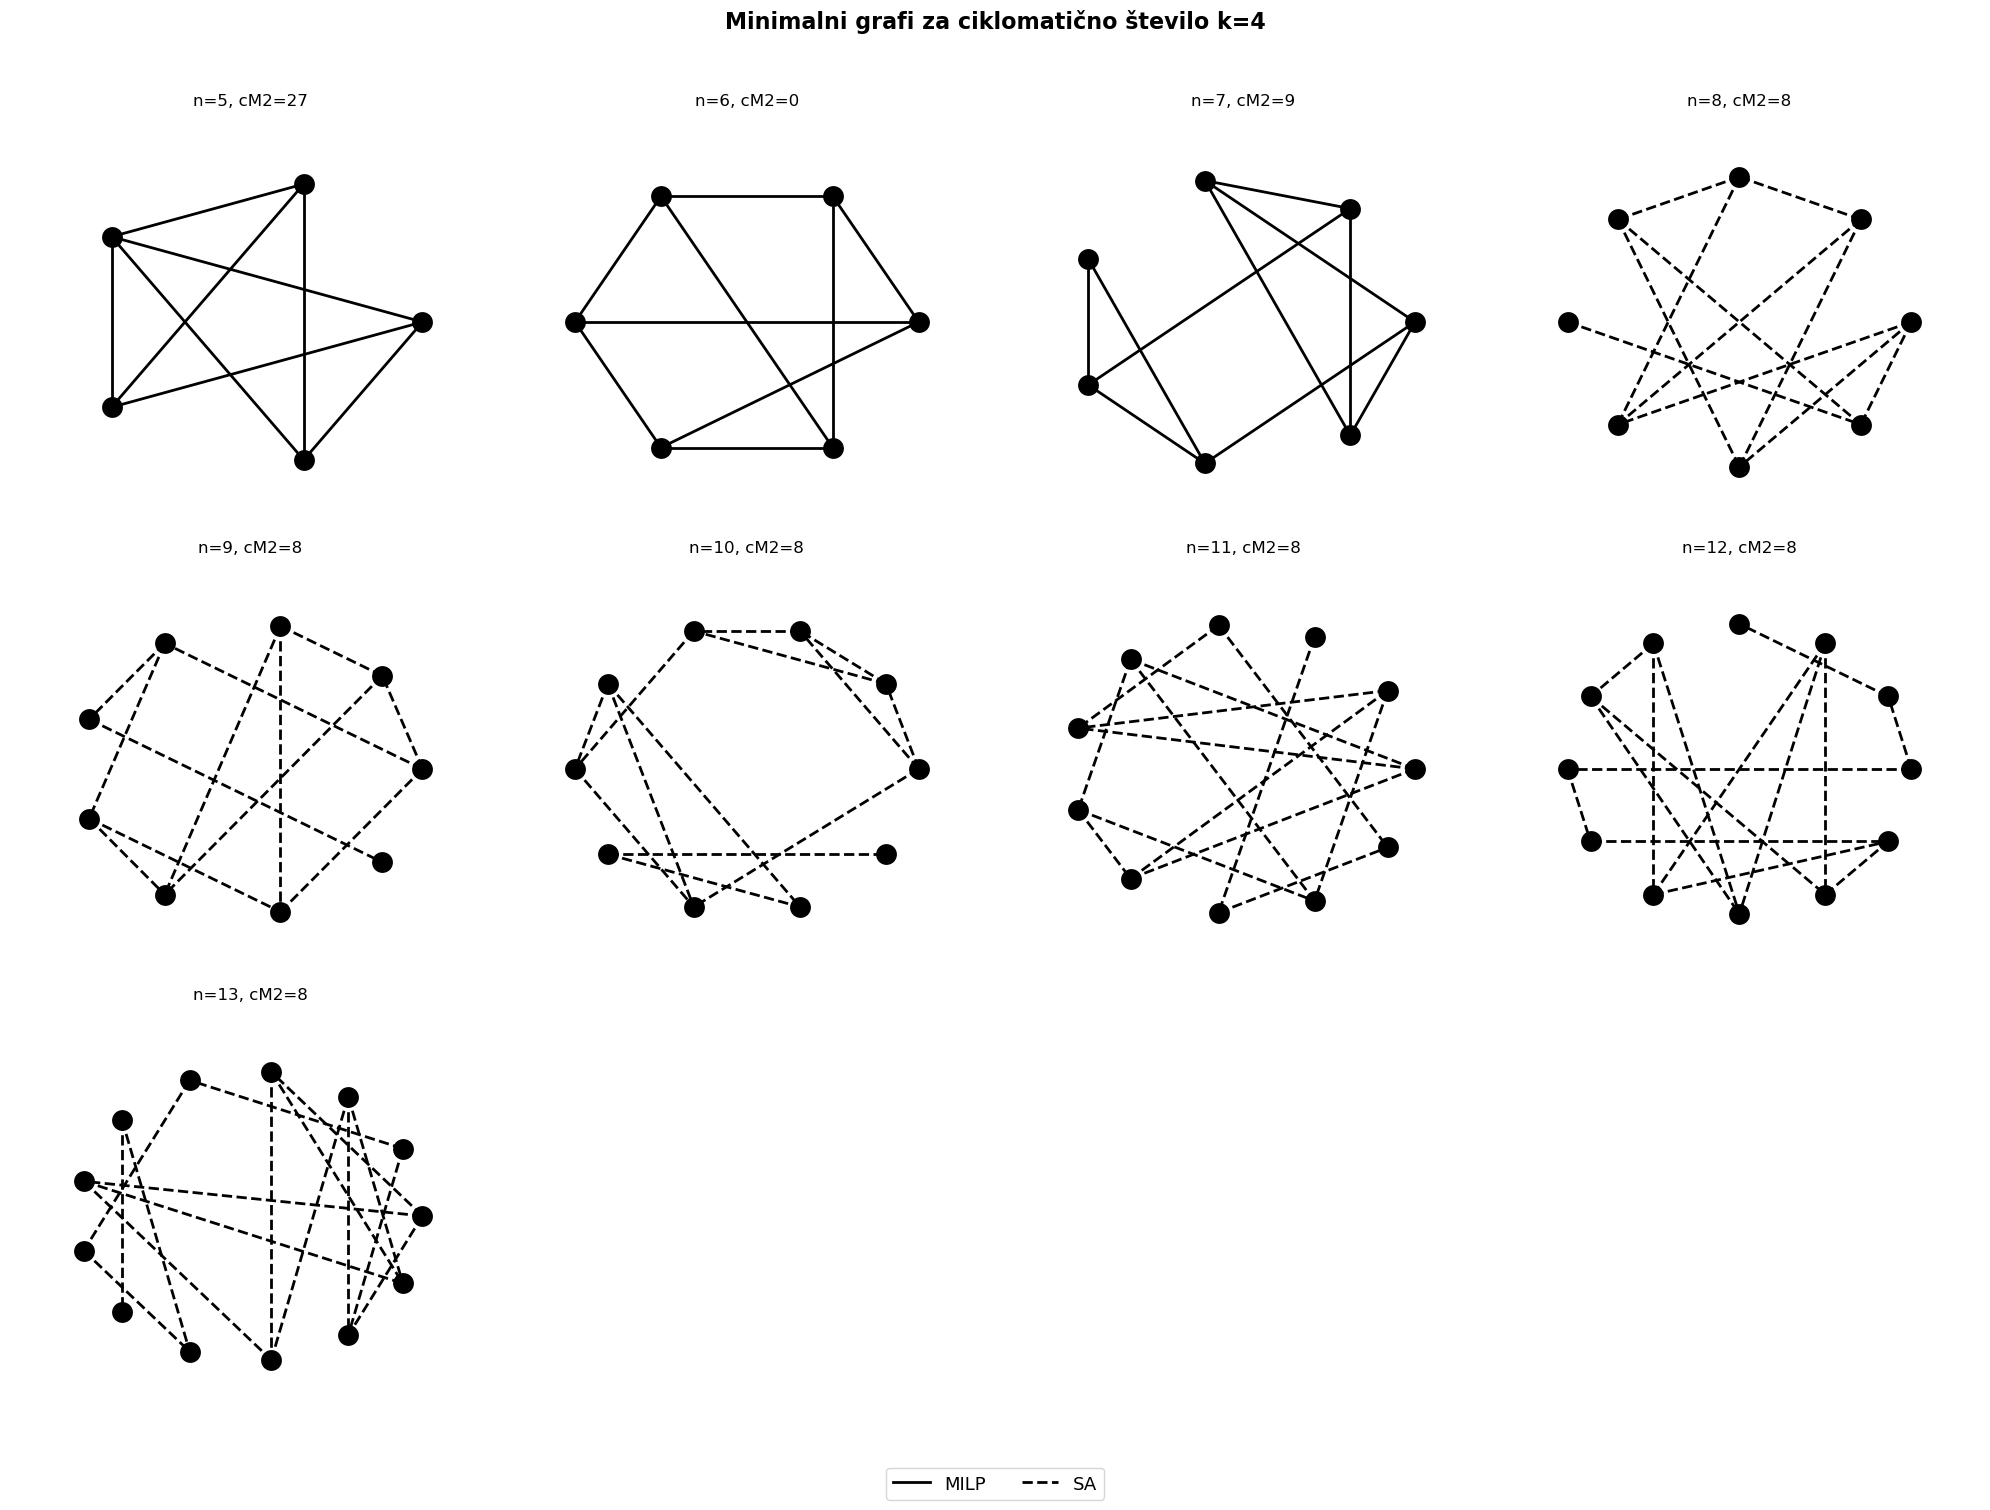

✓ Shranjeno: images/minimal_graphs/minimal_k5_final.png


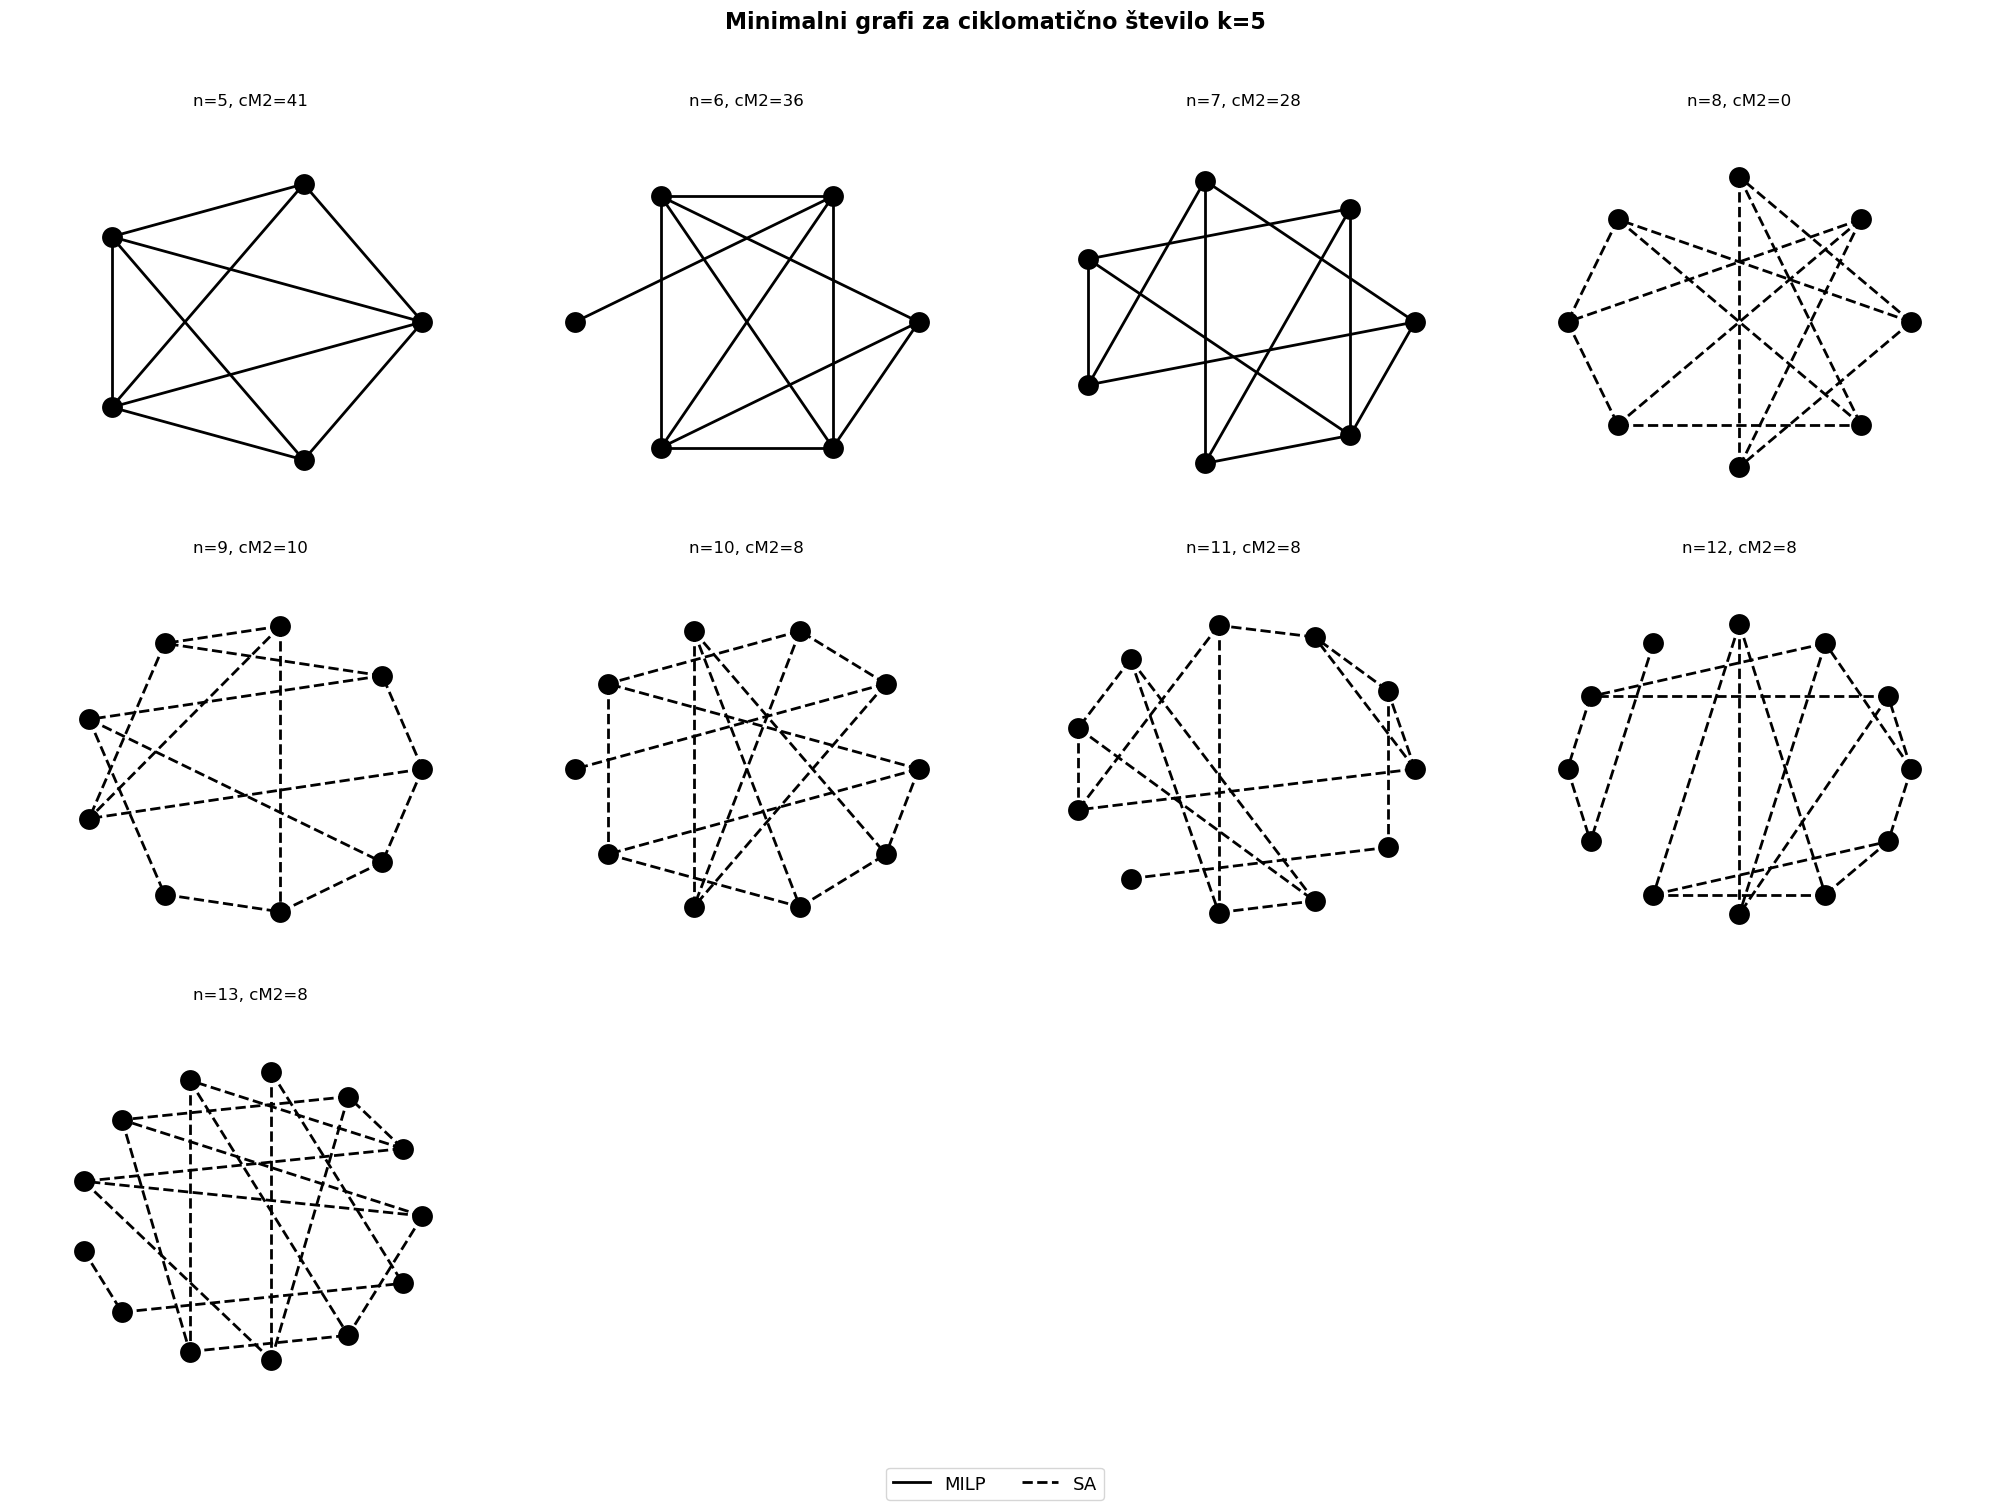

✓ Shranjeno: images/minimal_graphs/minimal_k6_final.png


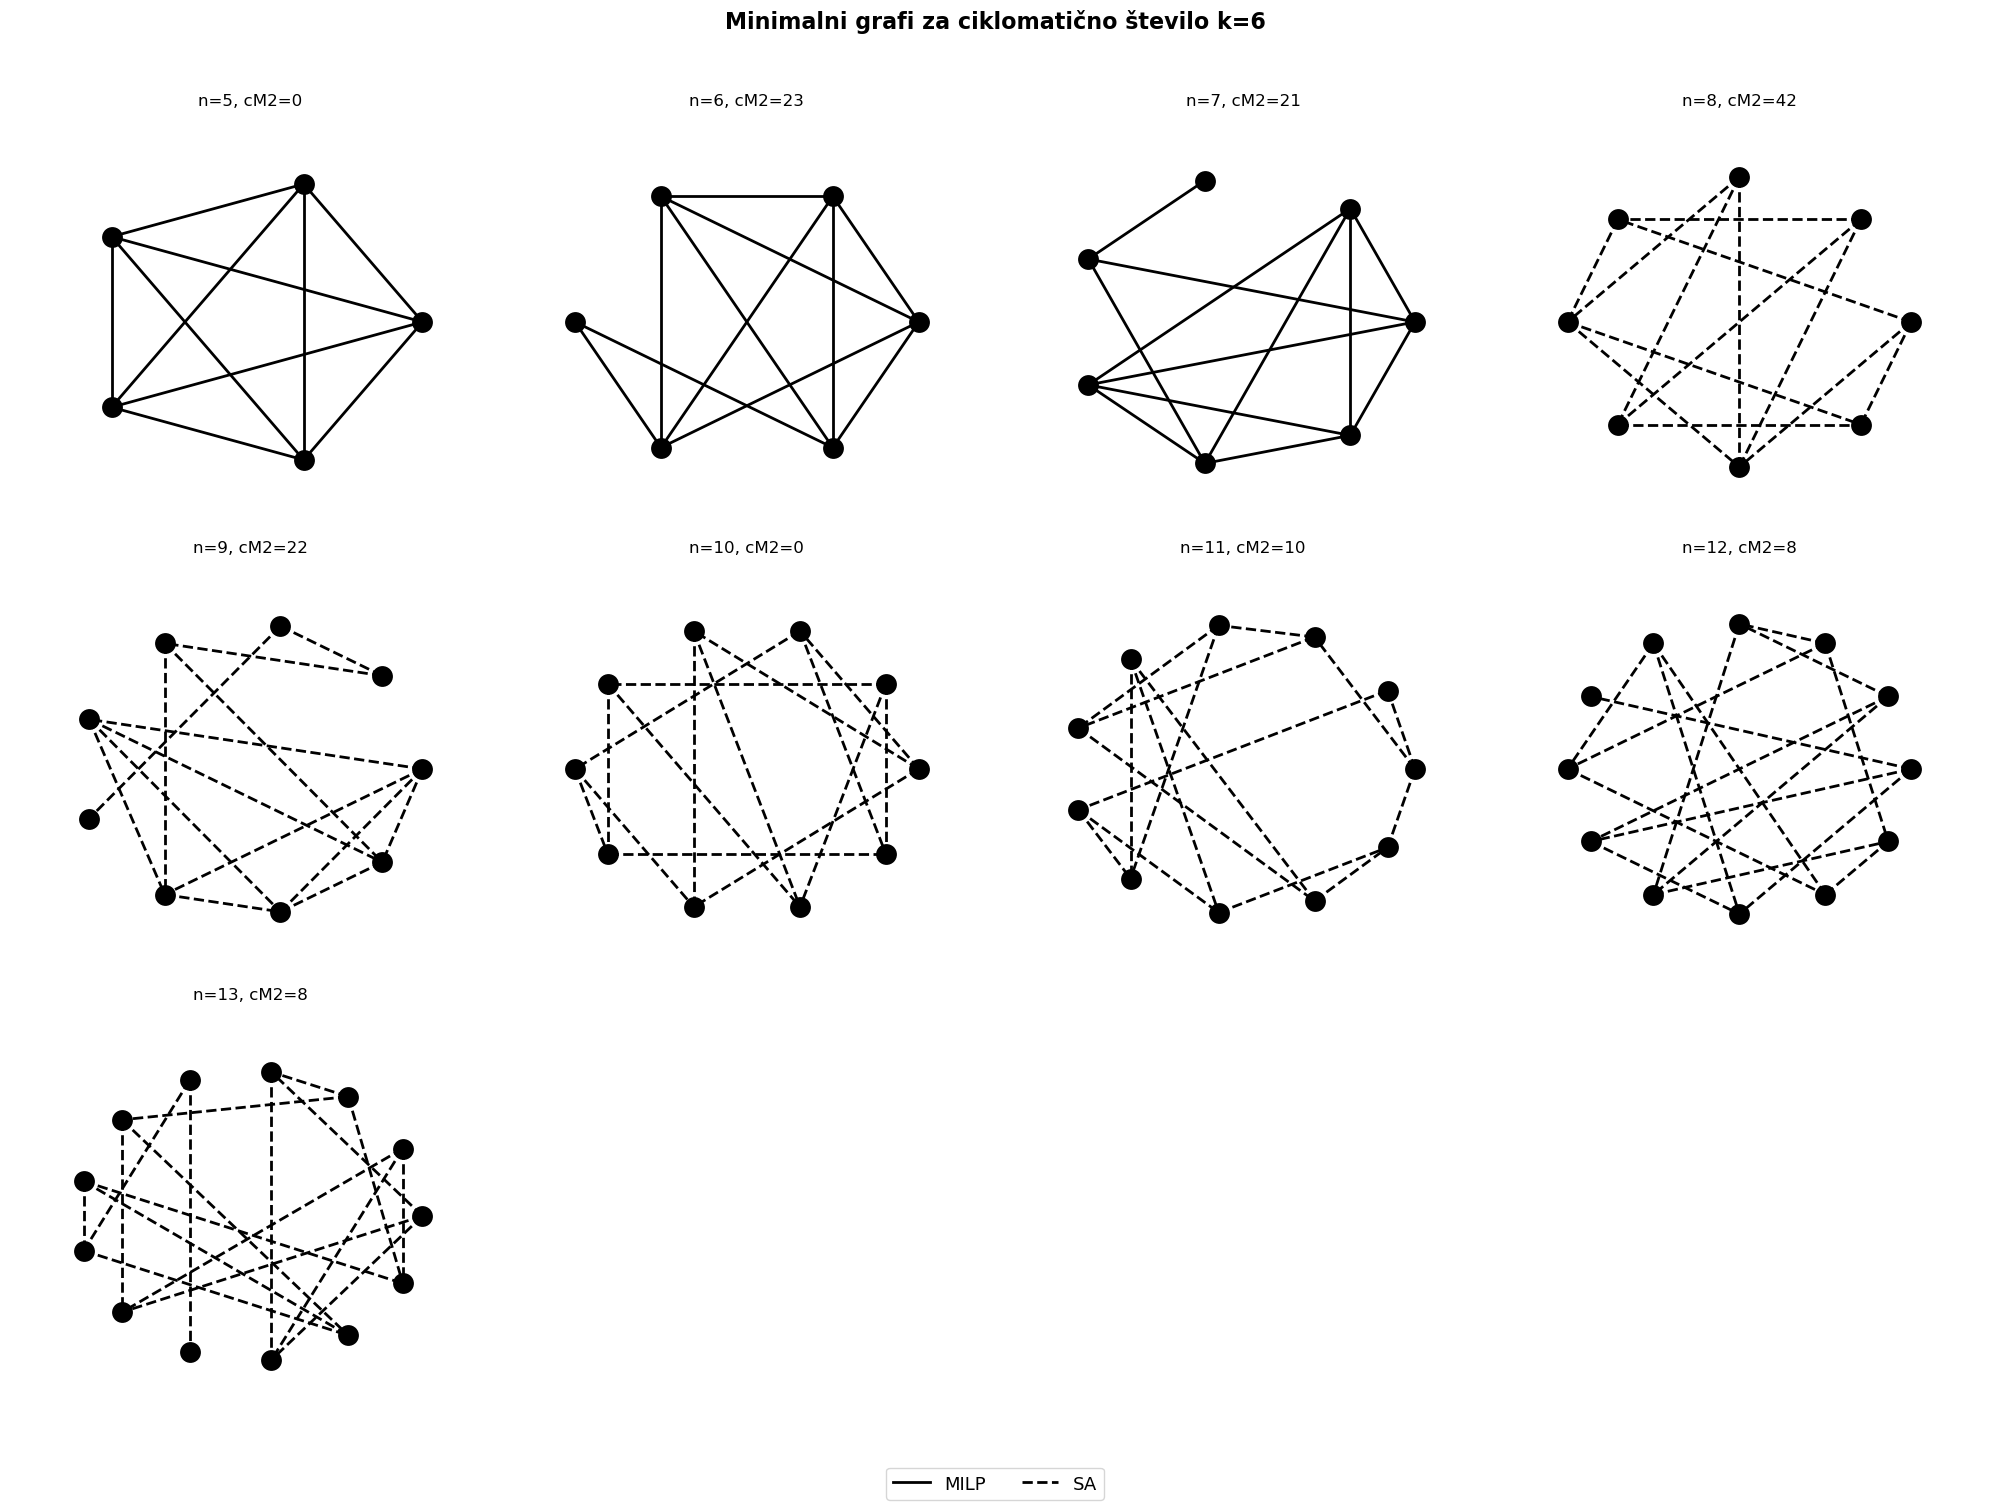

✓ Shranjeno: images/minimal_graphs/minimal_k7_final.png


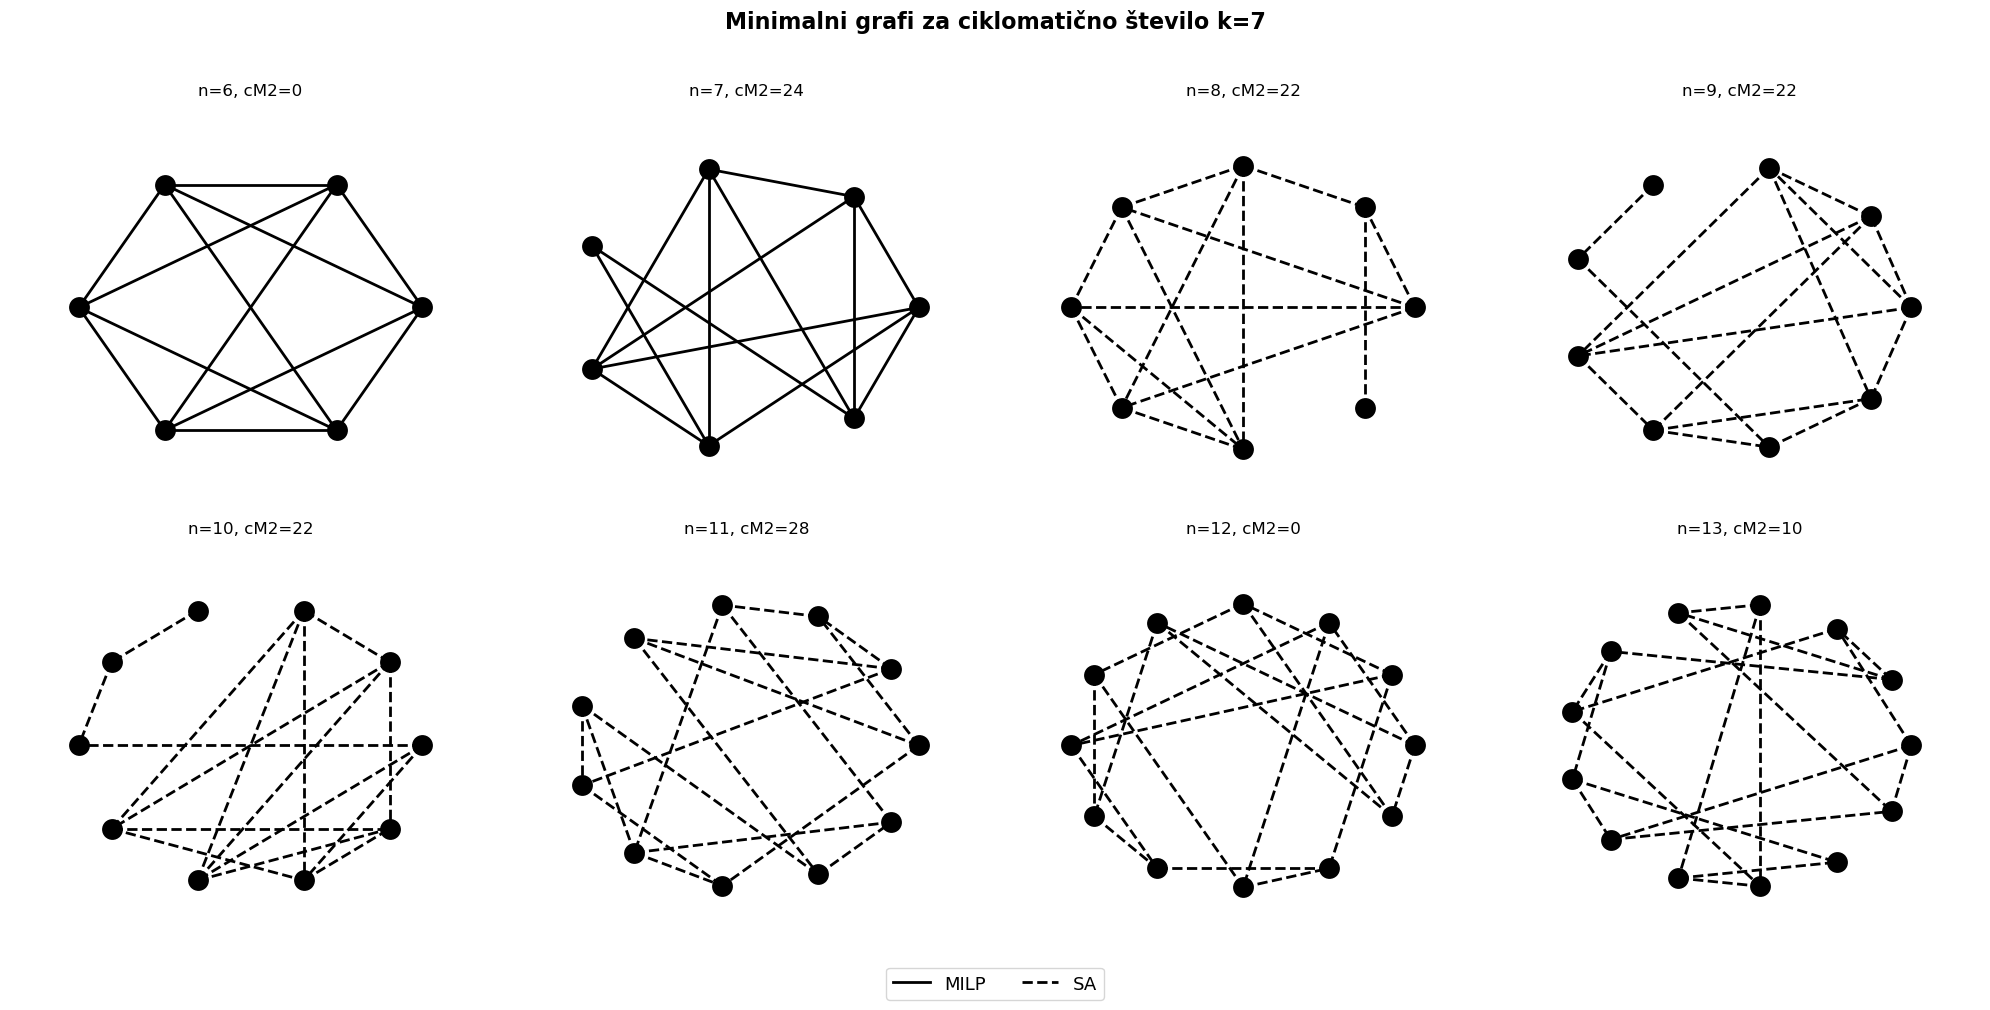

✓ Shranjeno: images/minimal_graphs/minimal_k8_final.png


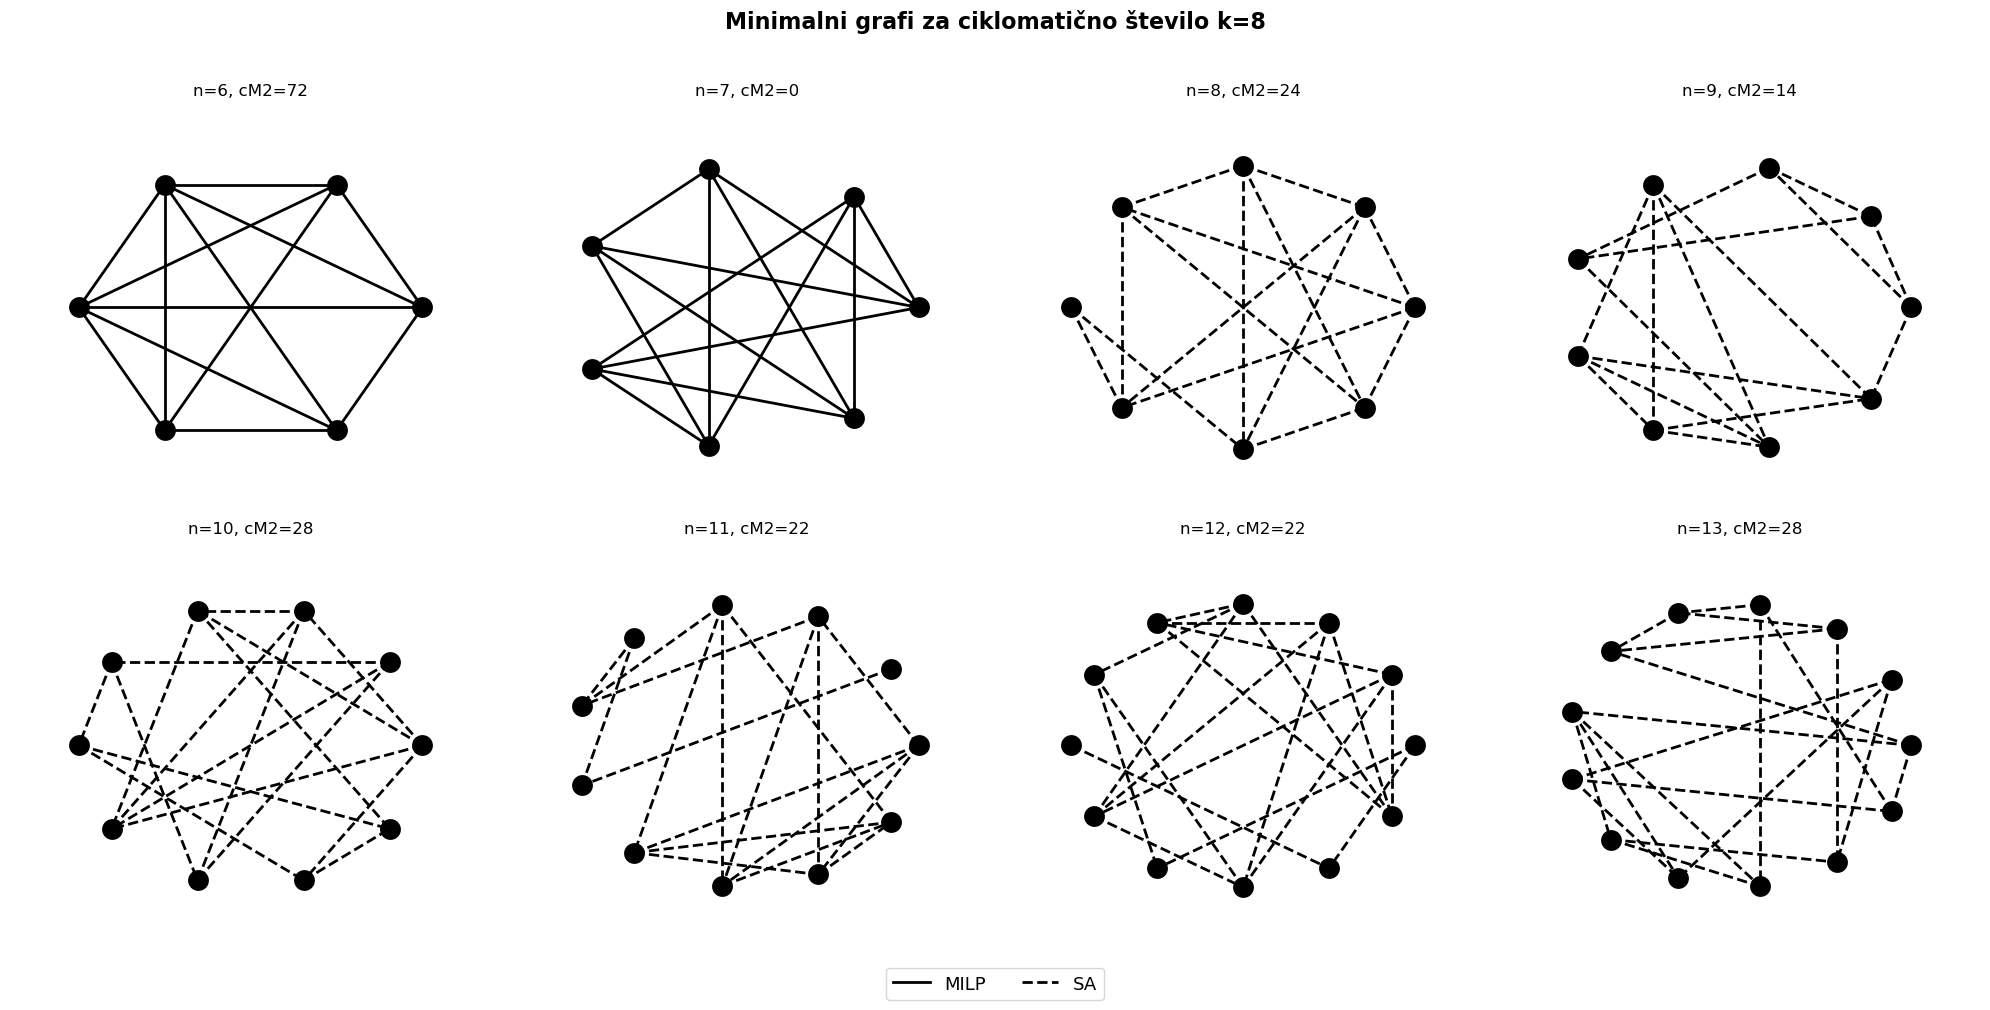

✓ Shranjeno: images/minimal_graphs/minimal_k9_final.png


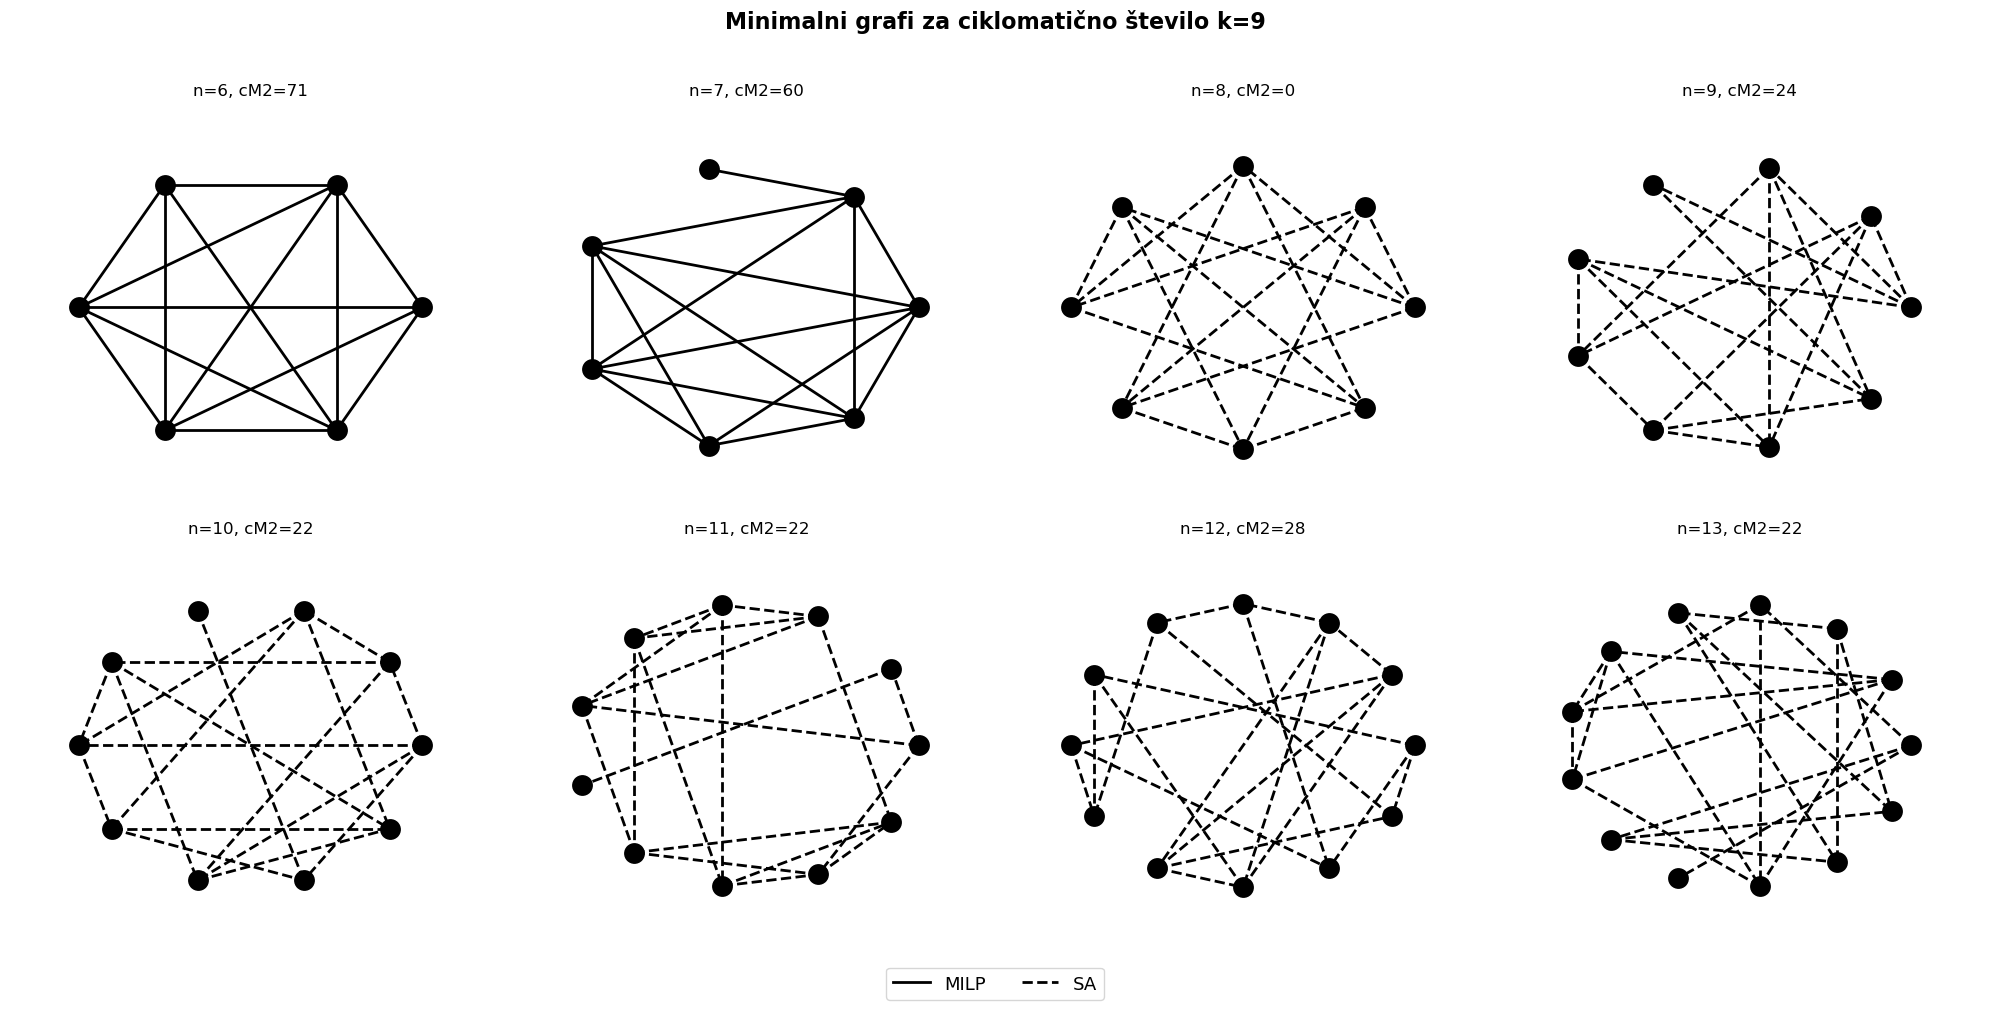

✓ Shranjeno: images/minimal_graphs/minimal_k10_final.png


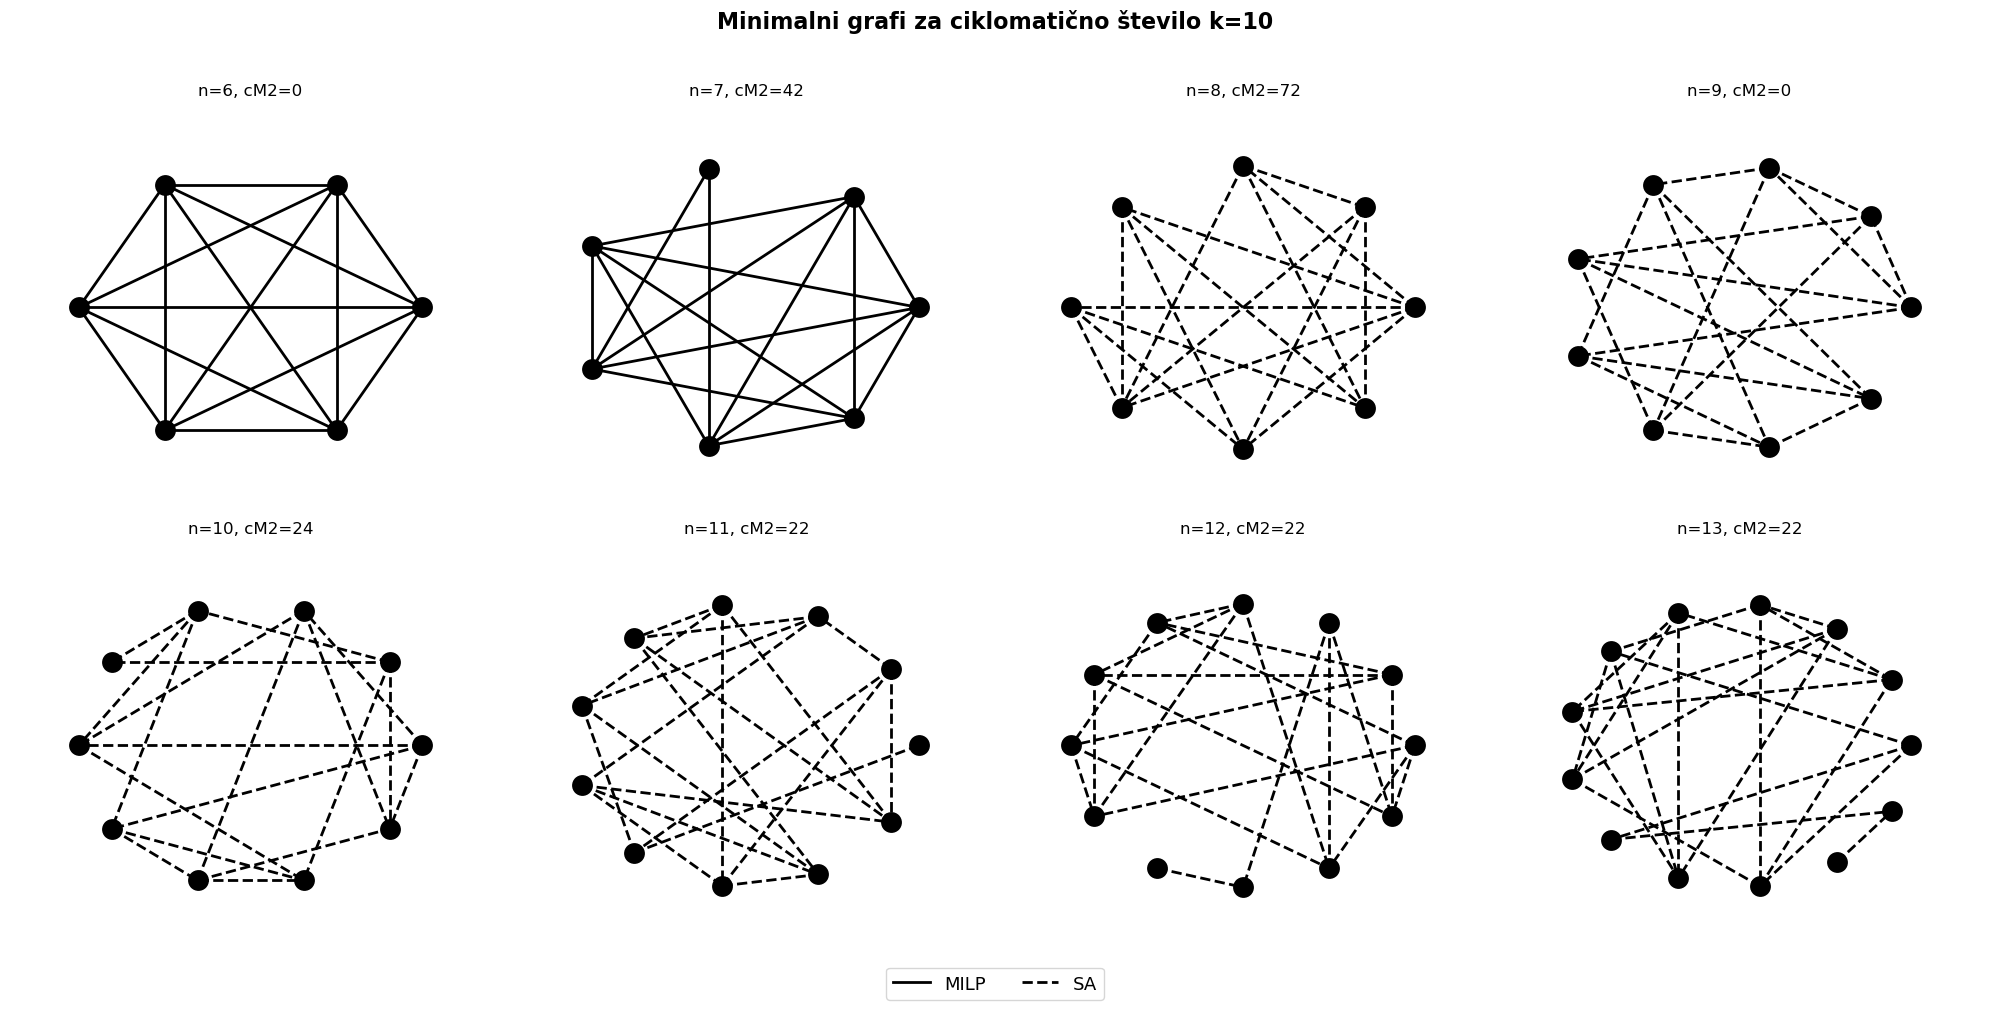

✓ Shranjeno: images/minimal_graphs/minimal_k11_final.png


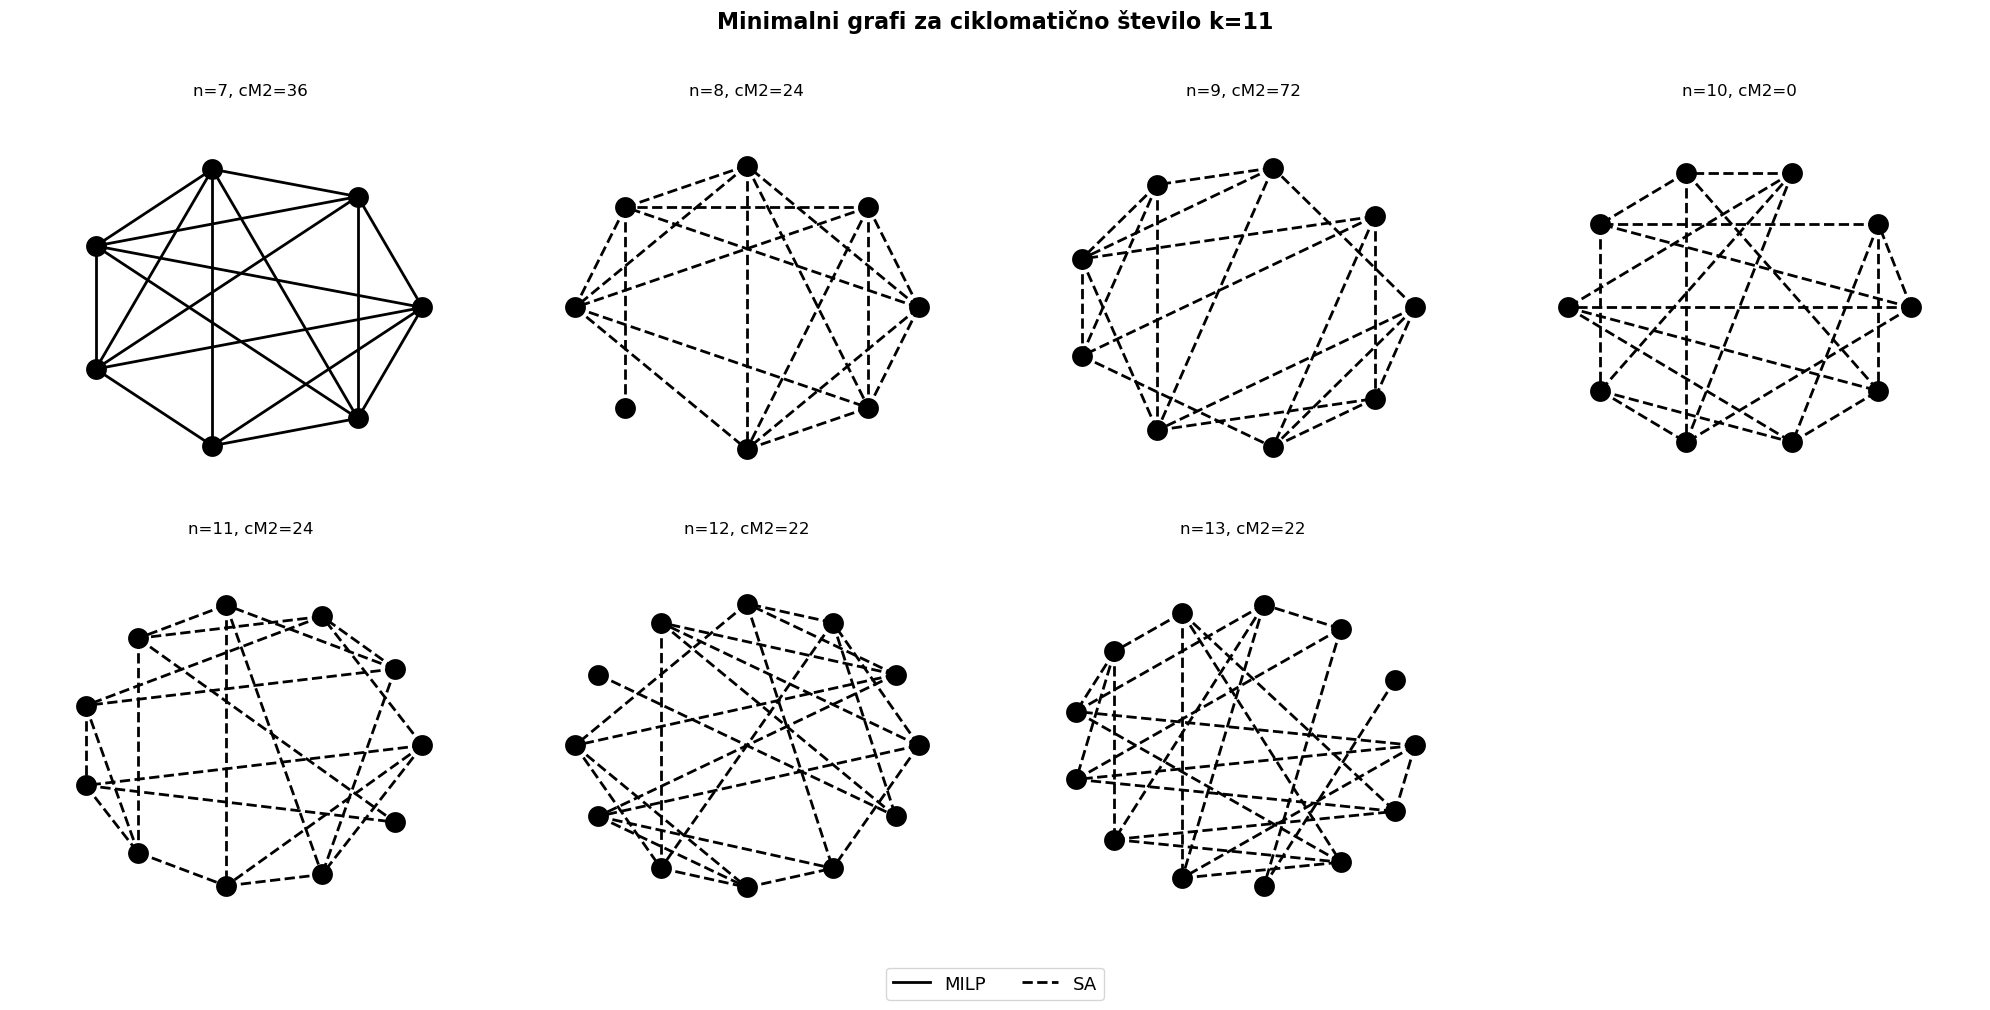

✓ Shranjeno: images/minimal_graphs/minimal_k12_final.png


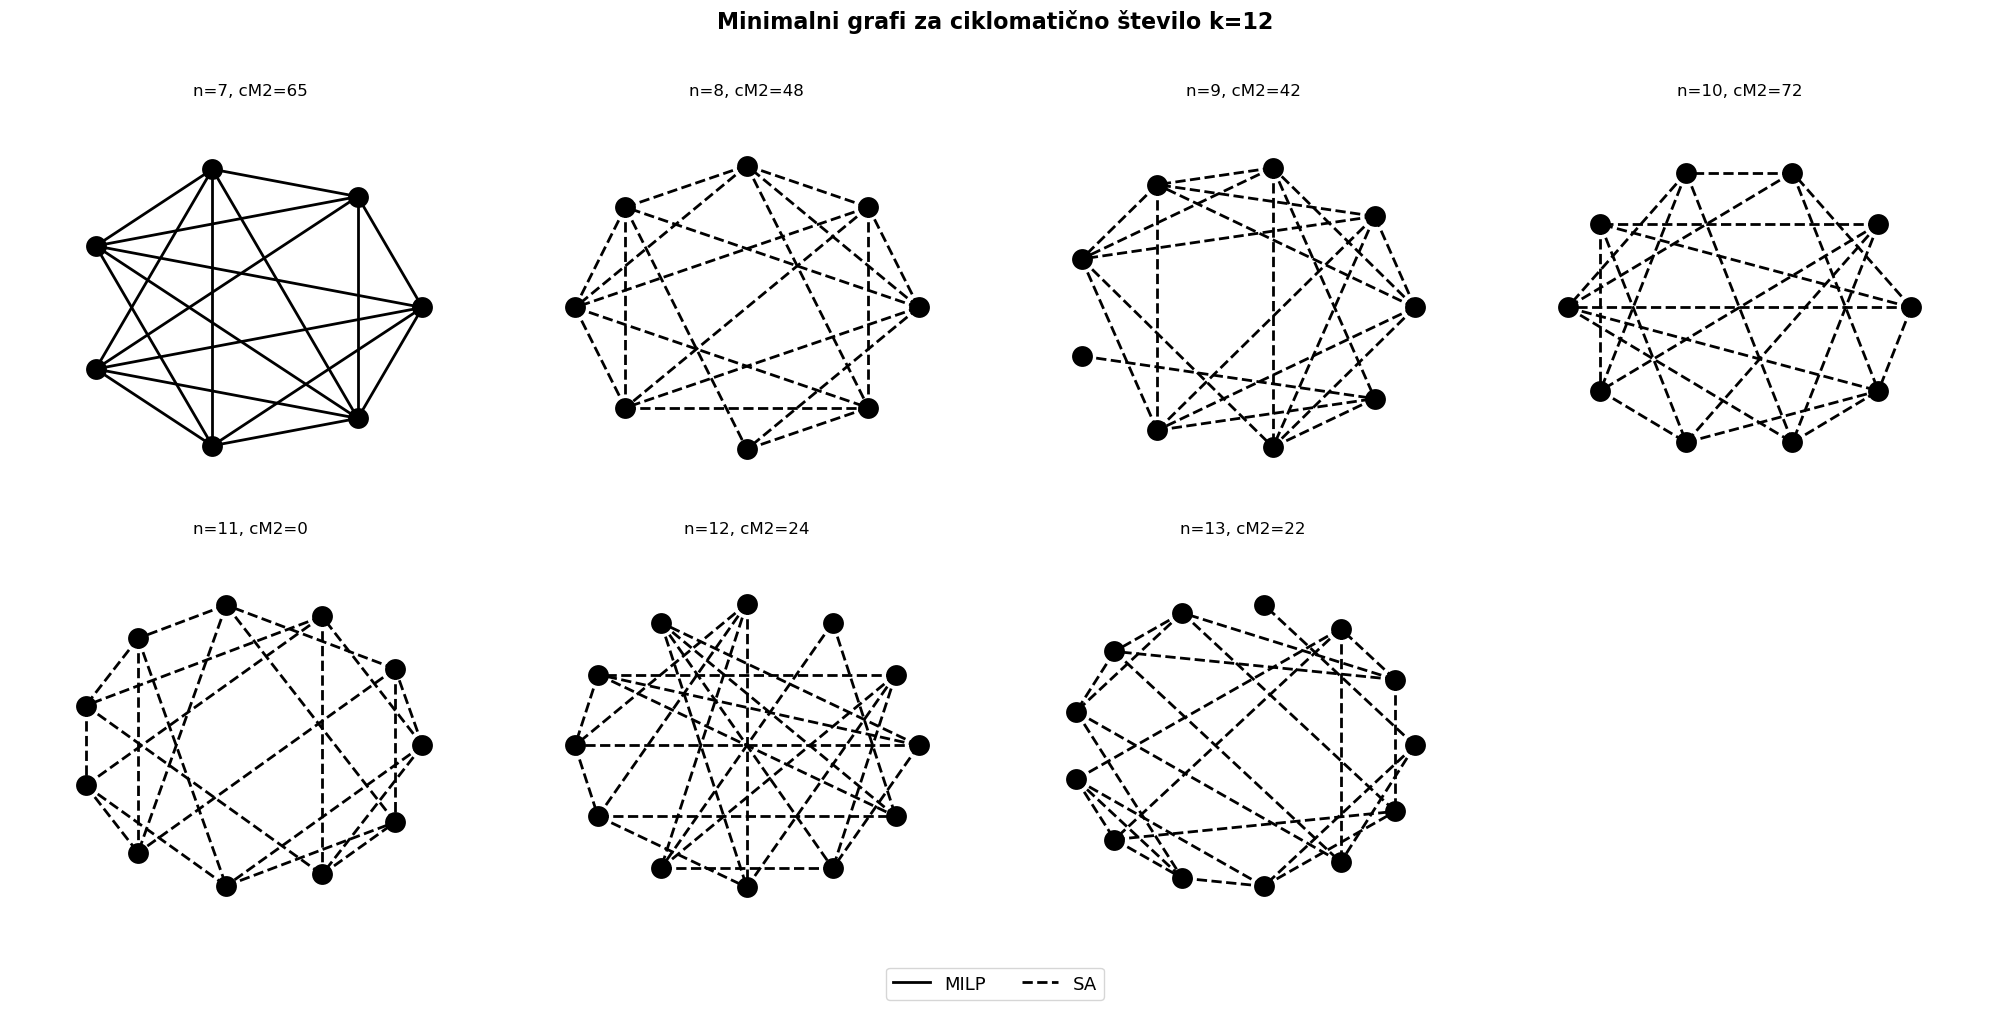


✓ Končano!


In [2]:
k_values = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
n_range = range(4, 14)
MILP_limit = 7

all_results = {}

for k in k_values:
    print(f"Min k={k}")
    results_k = []
    
    for n in n_range:
        if n <= MILP_limit:
            res = min_problem_MILP(n, k, verbose=False)
            if res:
                results_k.append((n, res, 'MILP'))
                print(f"n={n}, k={k}: MILP objective={res['objective']:.1f}")
        else:
            res = SA_networkx(n, k, minimize=True, T=8000, u=0.9,
                             num_runs=2, verbose=False)
            if res:
                results_k.append((n, res, 'SA'))
                print(f"n={n}, k={k}: SA objective={res['objective']:.1f}")
    
    if results_k:
        all_results[k] = results_k
    else:
        print(f"Ni rezultatov za k={k}")

for k in all_results.keys():
    results = all_results[k]
    num_graphs = len(results)
    
    if num_graphs == 0:
        continue
    
    cols = 4
    rows = (num_graphs + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(20, 5*rows))
    
    if rows == 1:
        axes_flat = list(axes) if hasattr(axes, '__iter__') else [axes]
    else:
        axes_flat = []
        for row in axes:
            if hasattr(row, '__iter__'):
                axes_flat.extend(row)
            else:
                axes_flat.append(row)
    
    for i in range(num_graphs, len(axes_flat)):
        axes_flat[i].axis('off')
    
    for idx, (n, res, method) in enumerate(results):
        ax = axes_flat[idx]
        
        G = Graph()
        G.add_edges(res['edges'])
        
        if G.num_verts() == 0:
            ax.axis('off')
            continue
        
        pos_dict = {}
        vertices = sorted(G.vertices())
        for i, vertex in enumerate(vertices):
            angle = 2 * math.pi * i / len(vertices)
            pos_dict[vertex] = [math.cos(angle), math.sin(angle)]
        
        linestyle = '-' if method == 'MILP' else '--'
        
        for edge in G.edges(labels=False):
            u, v = edge
            x_coords = [pos_dict[u][0], pos_dict[v][0]]
            y_coords = [pos_dict[u][1], pos_dict[v][1]]
            ax.plot(x_coords, y_coords, 'k' + linestyle, linewidth=2)
        
        for vertex in vertices:
            ax.plot(pos_dict[vertex][0], pos_dict[vertex][1], 'ko',
                    markersize=15, markerfacecolor='black', markeredgewidth=0)
        
        ax.set_title(f'n={len(vertices)}, cM2={int(res["objective"])}',
                     fontsize=12, pad=10)
        ax.set_xlim(-1.4, 1.4)
        ax.set_ylim(-1.4, 1.4)
        ax.axis('off')
    
    plt.suptitle(f'Minimalni grafi za ciklomatično število k={k}',
                 fontsize=16, fontweight='bold', y=0.98)
    
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], color='black', linewidth=2, linestyle='-',
               label='MILP'),
        Line2D([0], [0], color='black', linewidth=2, linestyle='--',
               label='SA')
    ]
    fig.legend(handles=legend_elements, loc='lower center',
               ncol=2, fontsize=13, frameon=True, bbox_to_anchor=(0.5, -0.02))
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.96])
    
    os.makedirs('images/minimal_graphs', exist_ok=True)
    filename = f'images/minimal_graphs/minimal_k{k}_final.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()